In [1]:
from data_prep.utils.config import setup_logging
import logging
setup_logging(log_level=logging.INFO)

# Set working directory to project root
from pathlib import Path
import os
from pyhere import here

os.chdir(here())

In [2]:
import pandas as pd
from pathlib import Path
import rioxarray as rxr
import xarray as xr


2025-03-30 10:09:11,161 - numexpr.utils - INFO - Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-03-30 10:09:11,161 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
# Load the EV data
ev_folder = Path("data/evs/")
boundary_path = Path("data/processed/boundary.geojson")


# Try to load the merged dataset first
merged_path = ev_folder / "all-evs.tif"


ev_stack = rxr.open_rasterio(merged_path, masked=True, band_as_variable=True)

import re

def tidy_name(name: str) -> str:
    """
    Cleans up the name of the variable by replacing dashes and spaces with underscores, 
    converting to lowercase, and stripping whitespace.
    """
    # Replace dashes and spaces with underscores
    name = re.sub(r'[- ]', '_', name)
    # Convert to lowercase
    name = name.lower()
    # Strip whitespace
    name = name.strip()
    # Remove any leading or trailing underscores
    name = name.strip('_')
    # Remove any trailing numbers
    name = re.sub(r'_\d+$', '', name)
    # Remove any trailing underscores
    name = name.rstrip('_')
    return name
# rename bands

name_mapping = {ev_stack[var].name : tidy_name(ev_stack[var].attrs["long_name"]) for var in ev_stack.data_vars}

ev_stack = ev_stack.rename(name_mapping)

ev_stack

<xarray.Dataset> Size: 422MB
Dimensions:                               (x: 1790, y: 1403)
Coordinates:
  * x                                     (x) float64 14kB 3.632e+05 ... 5.42...
  * y                                     (y) float64 11kB 3.786e+05 ... 5.18...
    spatial_ref                           int64 8B 0
Data variables: (12/42)
    ceh_landcover_broadleaved_woodland    (y, x) float32 10MB ...
    ceh_landcover_coniferous_woodland     (y, x) float32 10MB ...
    ceh_landcover_arable                  (y, x) float32 10MB ...
    ceh_landcover_improved_grassland      (y, x) float32 10MB ...
    ceh_landcover_urban                   (y, x) float32 10MB ...
    ceh_landcover_suburban                (y, x) float32 10MB ...
    ...                                    ...
    climate_temp_mat_avg                  (y, x) float32 10MB ...
    climate_prec_ann_var                  (y, x) float32 10MB ...
    climate_prec_ann_avg                  (y, x) float32 10MB ...
    climate_wind_ann_var                  (y, x) float32 10MB ...
    climate_wind_ann_avg                  (y, x) float32 10MB ...
    bgs_coast_distance_to_coast           (y, x) float32 10MB ...
Attributes:
    AREA_OR_POINT:  Area

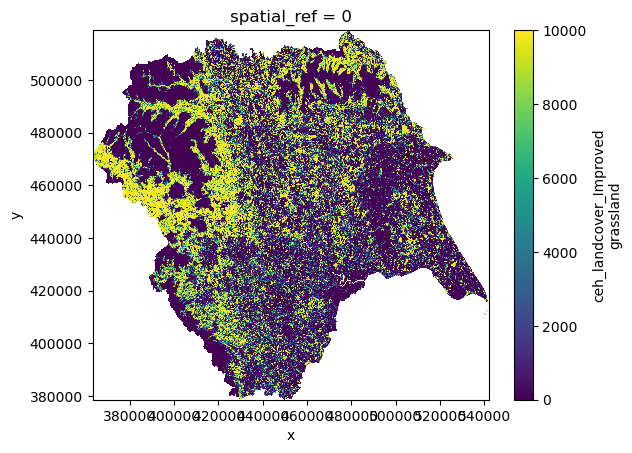

In [4]:
ev_stack["ceh_landcover_improved_grassland"].plot()

# Run some Checks

In [5]:
ev_df = ev_stack.to_dataframe()
ev_df.head()

spatial_ref  ceh_landcover_broadleaved_woodland  \
x        y                                                           
363250.0 378650.0            0                                 NaN   
         378750.0            0                                 NaN   
         378850.0            0                                 NaN   
         378950.0            0                                 NaN   
         379050.0            0                                 NaN   

                   ceh_landcover_coniferous_woodland  ceh_landcover_arable  \
x        y                                                                   
363250.0 378650.0                                NaN                   NaN   
         378750.0                                NaN                   NaN   
         378850.0                                NaN                   NaN   
         378950.0                                NaN                   NaN   
         379050.0                                NaN                   NaN   

                   ceh_landcover_improved_grassland  ceh_landcover_urban  \
x        y                                                                 
363250.0 378650.0                               NaN                  NaN   
         378750.0                               NaN                  NaN   
         378850.0                               NaN                  NaN   
         378950.0                               NaN                  NaN   
         379050.0                               NaN                  NaN   

                   ceh_landcover_suburban  ceh_landcover_grassland  \
x        y                                                           
363250.0 378650.0                     NaN                      NaN   
         378750.0                     NaN                      NaN   
         378850.0                     NaN                      NaN   
         378950.0                     NaN                      NaN   
         379050.0                     NaN                      NaN   

                   ceh_landcover_upland_heathland  ceh_landcover_wetland  ...  \
x        y                                                                ...   
363250.0 378650.0                             NaN                    NaN  ...   
         378750.0                             NaN                    NaN  ...   
         378850.0                             NaN                    NaN  ...   
         378950.0                             NaN                    NaN  ...   
         379050.0                             NaN                    NaN  ...   

                   os_distance_distance_to_water  \
x        y                                         
363250.0 378650.0                            NaN   
         378750.0                            NaN   
         378850.0                            NaN   
         378950.0                            NaN   
         379050.0                            NaN   

                   os_distance_distance_to_buildings  climate_temp_ann_var  \
x        y                                                                   
363250.0 378650.0                                NaN                   NaN   
         378750.0                                NaN                   NaN   
         378850.0                                NaN                   NaN   
         378950.0                                NaN                   NaN   
         379050.0                                NaN                   NaN   

                   climate_temp_ann_avg  climate_temp_mat_avg  \
x        y                                                      
363250.0 378650.0                   NaN                   NaN   
         378750.0                   NaN                   NaN   
         378850.0                   NaN                   NaN   
         378950.0                   NaN                   NaN   
         379050.0                   NaN                   NaN   

                   cl

In [6]:
ev_df.drop(columns=["spatial_ref"], inplace=True)

## Missing Values

There should be some missing values where I've clipped the data using a buffer but it should be less than 45%.

In [7]:
# Count the missing values per variable and sor tin descending order
baseline_missing : float = 0.45
ev_df.isna().mean().sort_values(ascending=False).to_frame(name="missing_fraction").query("missing_fraction > @baseline_missing")

,missing_fraction


## Visualise some of the missing values


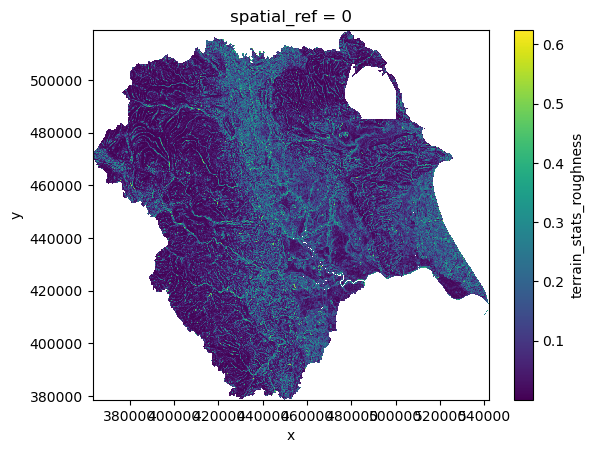

In [8]:
ev_stack["terrain_stats_roughness"].plot()

Where are the missing values in the dataset?

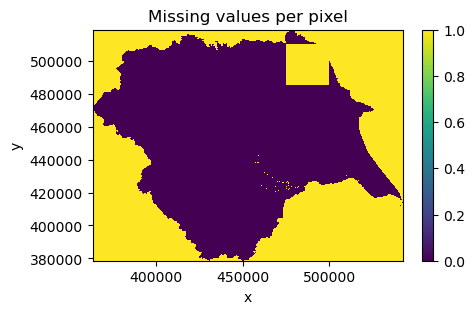

In [9]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
np.isnan(ev_stack.to_array()).any(axis=0).plot(ax = ax)
# add title
ax.set_title("Missing values per pixel")

plt.show()


# Visualise the EV Distributions


/var/folders/w6/z6wv9w5s4r77c8m0lp63lm1w0000gp/T/ipykernel_88143/3896634676.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=ev_df_melted, y='Variable', x='Value', scale='width', inner='quartile')


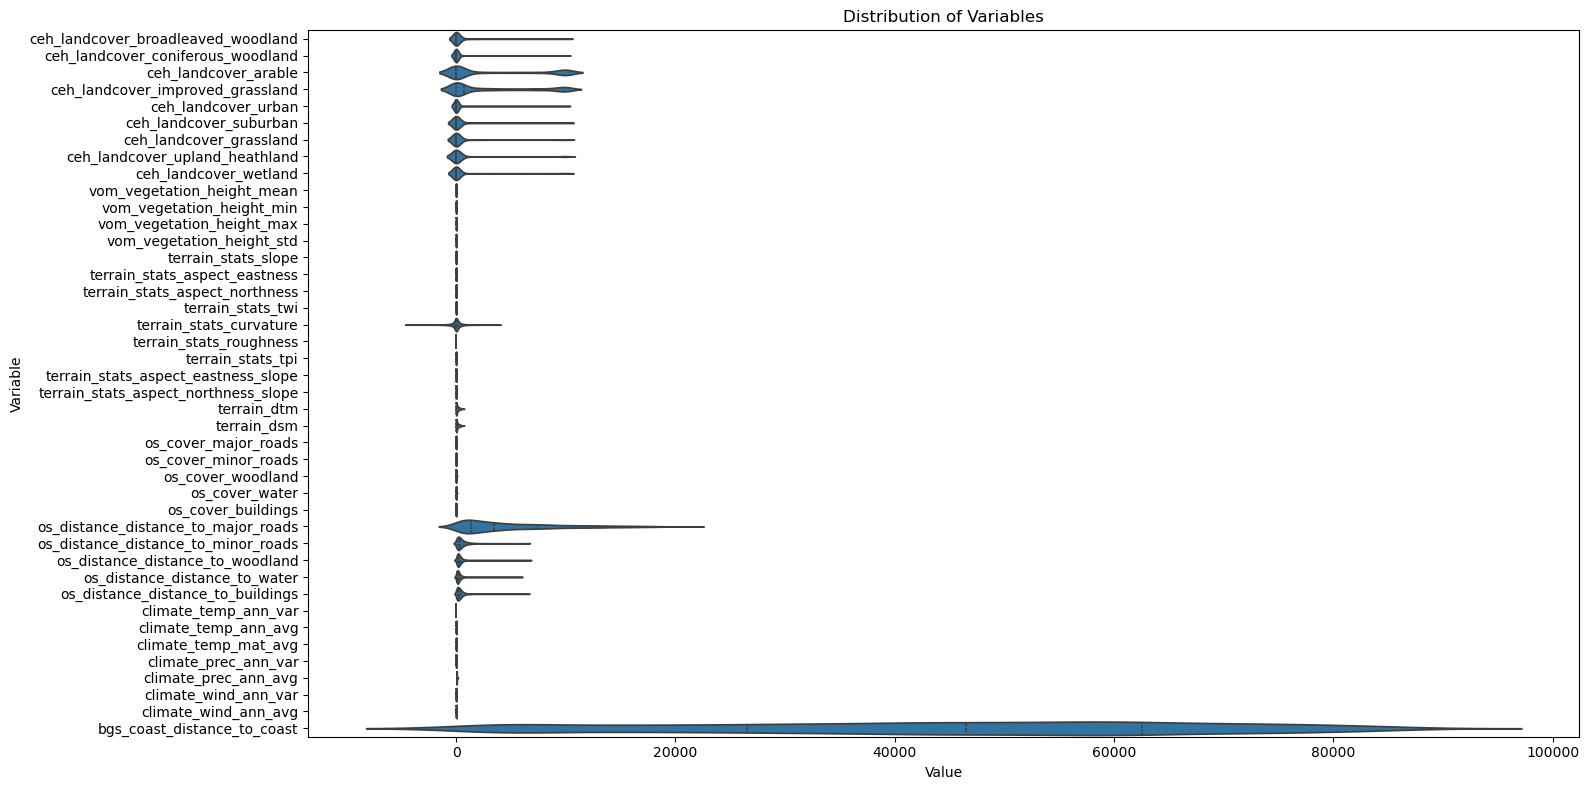

In [11]:
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Melt the DataFrame to long format for seaborn
ev_df_melted = ev_df.reset_index().sample(10_000).melt(id_vars=['x', 'y'], var_name='Variable', value_name='Value')

# Create the violin plot
plt.figure(figsize=(16, 8))
sns.violinplot(data=ev_df_melted, y='Variable', x='Value', scale='width', inner='quartile')

plt.title('Distribution of Variables')
plt.tight_layout()
plt.show()

<Axes: >

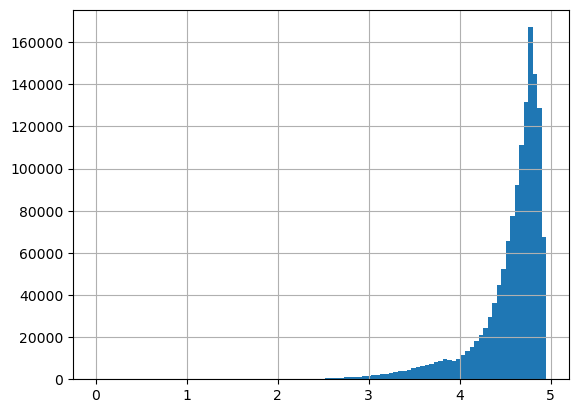

In [ ]:
## histogram of coastline distance

def transform_distance(distance_m: pd.Series,
                       max_distance_m: float = 5000,
                       epsilon: float = 0.001,
                       ) -> pd.Series:
    """"
    1/(1+e −k⋅(threshold−distance))
    """
    

np.log10(ev_df["bgs_coast_distance_to_coast"] + 1).hist(bins=100)

# Calculate EV Correlations

In [12]:
ev_df.dropna(inplace=True)

ev_correlations = ev_df.sample(10_000).corr()
ev_correlations.head()

,ceh_landcover_broadleaved_woodland,ceh_landcover_coniferous_woodland,ceh_landcover_arable,ceh_landcover_improved_grassland,ceh_landcover_urban,ceh_landcover_suburban,ceh_landcover_grassland,ceh_landcover_upland_heathland,ceh_landcover_wetland,vom_vegetation_height_mean,...,os_distance_distance_to_water,os_distance_distance_to_buildings,climate_temp_ann_var,climate_temp_ann_avg,climate_temp_mat_avg,climate_prec_ann_var,climate_prec_ann_avg,climate_wind_ann_var,climate_wind_ann_avg,bgs_coast_distance_to_coast
ceh_landcover_broadleaved_woodland,1.000000,0.069346,-0.189684,-0.057802,-0.048070,-0.060134,-0.082983,-0.084025,-0.072269,0.677205,...,-0.051591,-0.065197,0.014818,0.071502,0.069618,-0.080855,-0.081382,-0.098348,-0.115860,0.090768
ceh_landcover_coniferous_woodland,0.069346,1.000000,-0.105016,-0.081162,-0.027667,-0.043547,-0.017253,-0.010079,-0.029018,0.503509,...,-0.024709,0.033176,-0.119336,-0.122684,-0.126270,0.084779,0.089971,0.088264,0.064358,0.026108
ceh_landcover_arable,-0.189684,-0.105016,1.000000,-0.479914,-0.132850,-0.233425,-0.230143,-0.222627,-0.179110,-0.208478,...,0.139110,-0.054613,0.393178,0.419575,0.387779,-0.494801,-0.496641,-0.362497,-0.170316,-0.361412
ceh_landcover_improved_grassland,-0.057802,-0.081162,-0.479914,1.000000,-0.110217,-0.140837,-0.193983,-0.199505,-0.193497,-0.002218,...,-0.157291,-0.248107,-0.118600,0.089726,0.083471,-0.051790,-0.062689,-0.188223,-0.234074,0.105217
ceh_landcover_urban,-0.048070,-0.027667,-0.132850,-0.110217,1.000000,0.206305,-0.067192,-0.063373,-0.051526,-0.039055,...,-0.009483,-0.135758,0.162004,0.161088,0.180470,-0.079801,-0.086860,-0.107922,-0.104756,0.080410


Some of the correlations ar NA because the values are all 0 in the dataset. This is where that land cover feature doesn't exist inland and should just be converted to NA.

In [13]:
ev_correlations.fillna(0, inplace=True)

/var/folders/w6/z6wv9w5s4r77c8m0lp63lm1w0000gp/T/ipykernel_88143/1657080385.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(distance, method='ward')


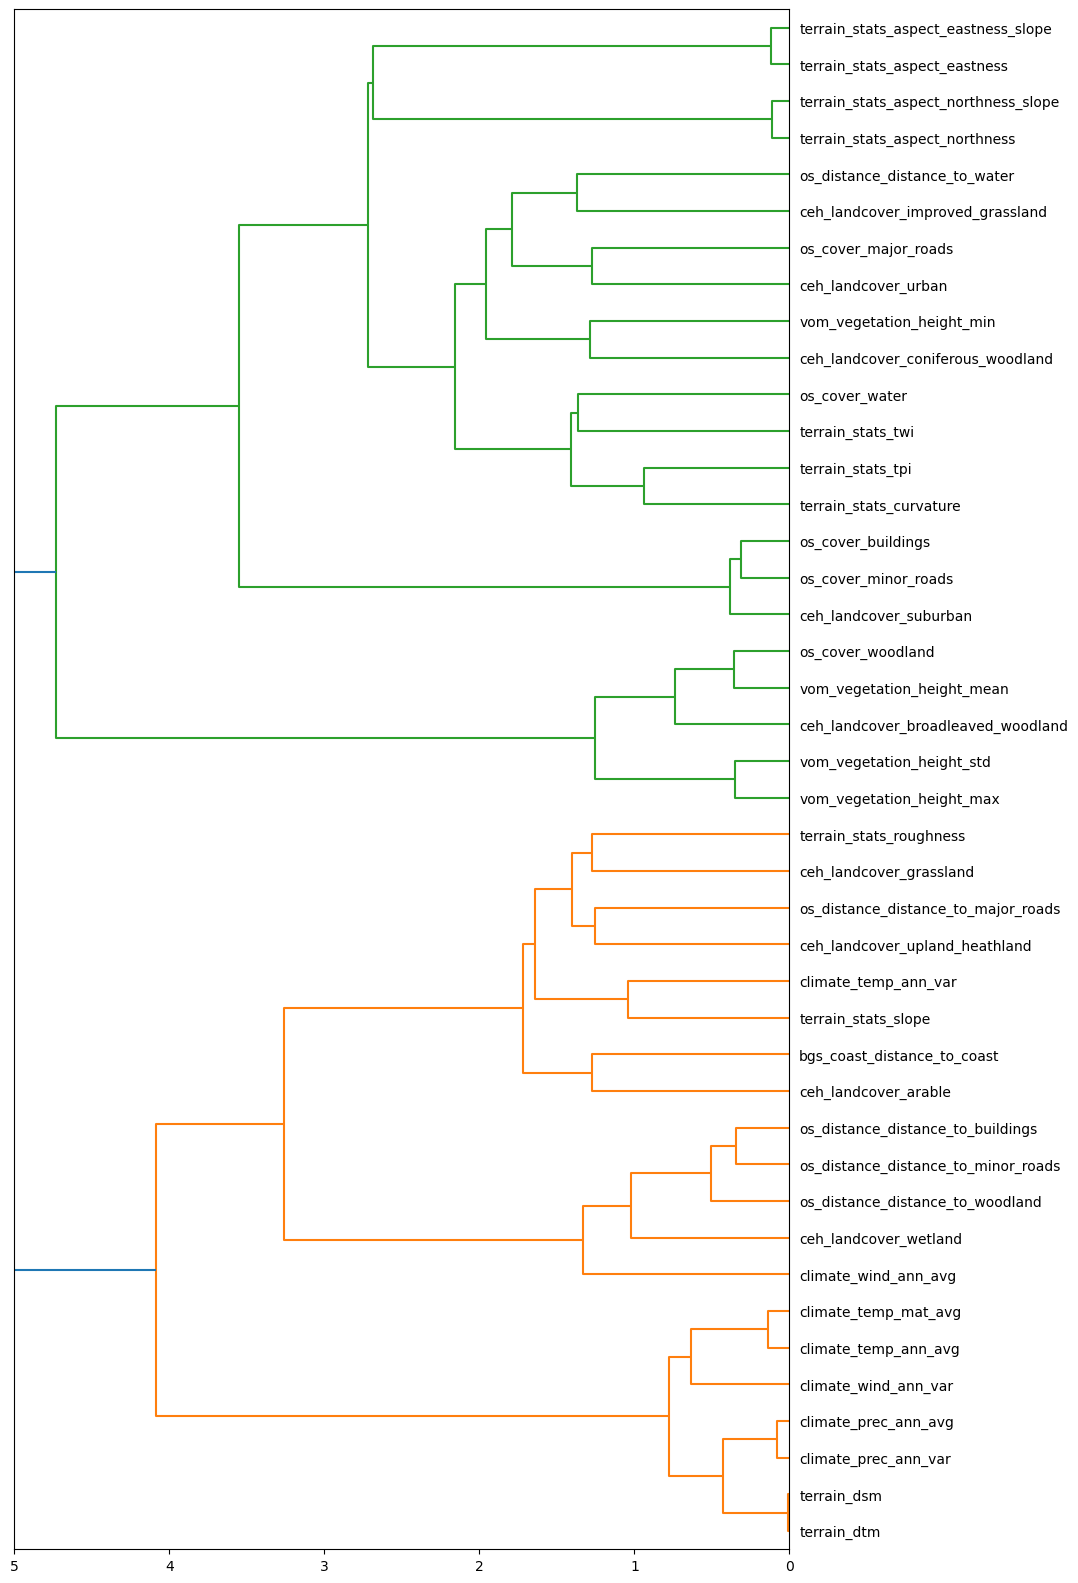

In [14]:
from scipy.cluster import hierarchy

# Calculate distance between each variable (1 - correlation to have a sense of distance)
distance = 1 - ev_correlations.abs()

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(distance, method='ward')

plt.figure(figsize=(10,20))
hierarchy.dendrogram(linkage_matrix, labels=ev_correlations.columns.tolist(), orientation="left", leaf_font_size=10)
plt.xlim(5, 0)
plt.show()

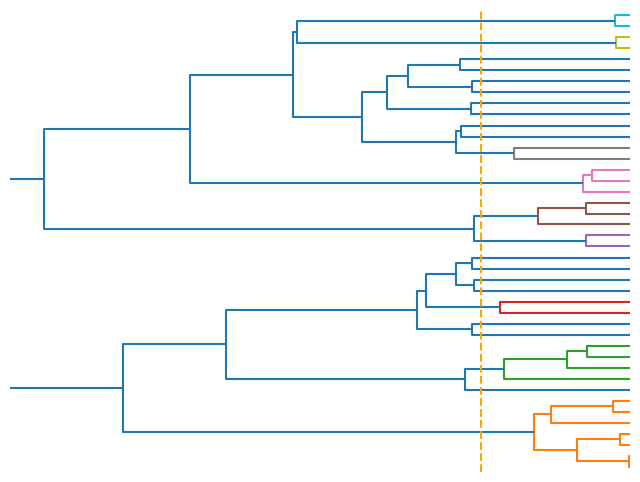

In [15]:

plt.figure(figsize=(8,6))

cut_height = 1.2
hierarchy.dendrogram(
    linkage_matrix,
    no_labels=True, 
    orientation="left",
    color_threshold=cut_height,
    )
# add a vertical line to mark the threshold
plt.axvline(x=cut_height, color='orange', linestyle='--')
plt.xlim(5, 0)
# drop the panel
plt.gca().set_axis_off()
background_color = "#eeeeee"
# set panel background color
plt.gca().patch.set_facecolor(background_color)
plt.show()

In [35]:
# Cluster the samples
cluster_ids = hierarchy.fcluster(linkage_matrix, t=1.2, criterion='distance')

# Create a DataFrame to see clusters
column_clusters = pd.DataFrame({'cluster_id': cluster_ids, 'column_name': ev_df.columns})
print(column_clusters.cluster_id.value_counts().sort_index())

1     7
2     4
3     1
4     2
5     3
6     2
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    2
16    2
17    3
18    1
19    1
20    2
21    1
22    1
23    1
24    1
Name: cluster_id, dtype: int64


In [36]:
column_clusters = column_clusters.sort_values("cluster_id")
column_clusters.to_csv("data/evs/ev_clusters.csv", index=False)